<a href="https://colab.research.google.com/github/standroidbeta/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

This is the orginal code example that I have chosen to use.

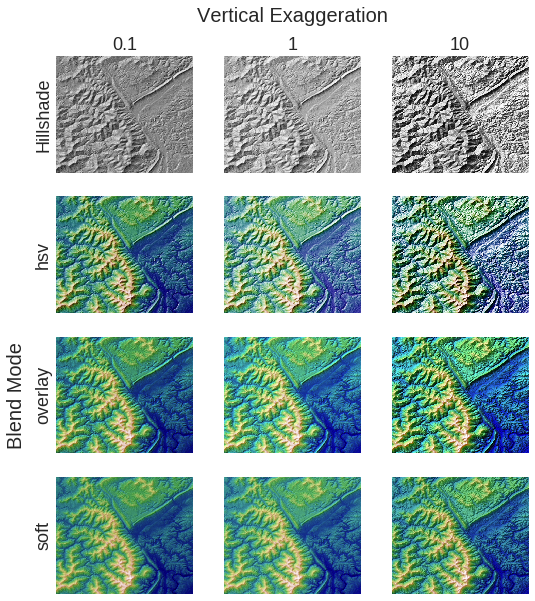

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource


with np.load(get_sample_data('jacksboro_fault_dem.npz')) as dem:
    z = dem['elevation']

    #-- Optional dx and dy for accurate vertical exaggeration ----------------
    # If you need topographically accurate vertical exaggeration, or you don't
    # want to guess at what *vert_exag* should be, you'll need to specify the
    # cellsize of the grid (i.e. the *dx* and *dy* parameters).  Otherwise, any
    # *vert_exag* value you specify will be relative to the grid spacing of
    # your input data (in other words, *dx* and *dy* default to 1.0, and
    # *vert_exag* is calculated relative to those parameters).  Similarly, *dx*
    # and *dy* are assumed to be in the same units as your input z-values.
    # Therefore, we'll need to convert the given dx and dy from decimal degrees
    # to meters.
    dx, dy = dem['dx'], dem['dy']
    dy = 111200 * dy
    dx = 111200 * dx * np.cos(np.radians(dem['ymin']))
    #-------------------------------------------------------------------------

# Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 9))
plt.setp(axes.flat, xticks=[], yticks=[])

# Vary vertical exaggeration and blend mode and plot all combinations
for col, ve in zip(axes.T, [0.1, 1, 10]):
    # Show the hillshade intensity image in the first row
    col[0].imshow(ls.hillshade(z, vert_exag=ve, dx=dx, dy=dy), cmap='gray')

    # Place hillshaded plots with different blend modes in the rest of the rows
    for ax, mode in zip(col[1:], ['hsv', 'overlay', 'soft']):
        rgb = ls.shade(z, cmap=cmap, blend_mode=mode,
                       vert_exag=ve, dx=dx, dy=dy)
        ax.imshow(rgb)

# Label rows and columns
for ax, ve in zip(axes[0], [0.1, 1, 10]):
    ax.set_title('{0}'.format(ve), size=18)
for ax, mode in zip(axes[:, 0], ['Hillshade', 'hsv', 'overlay', 'soft']):
    ax.set_ylabel(mode, size=18)

# Group labels...
axes[0, 1].annotate('Vertical Exaggeration', (0.5, 1), xytext=(0, 30),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='center', va='bottom', size=20)
axes[2, 0].annotate('Blend Mode', (0, 0.5), xytext=(-30, 0),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='right', va='center', size=20, rotation=90)
fig.subplots_adjust(bottom=0.05, right=0.95)

plt.show()

This is the example with my modifications.

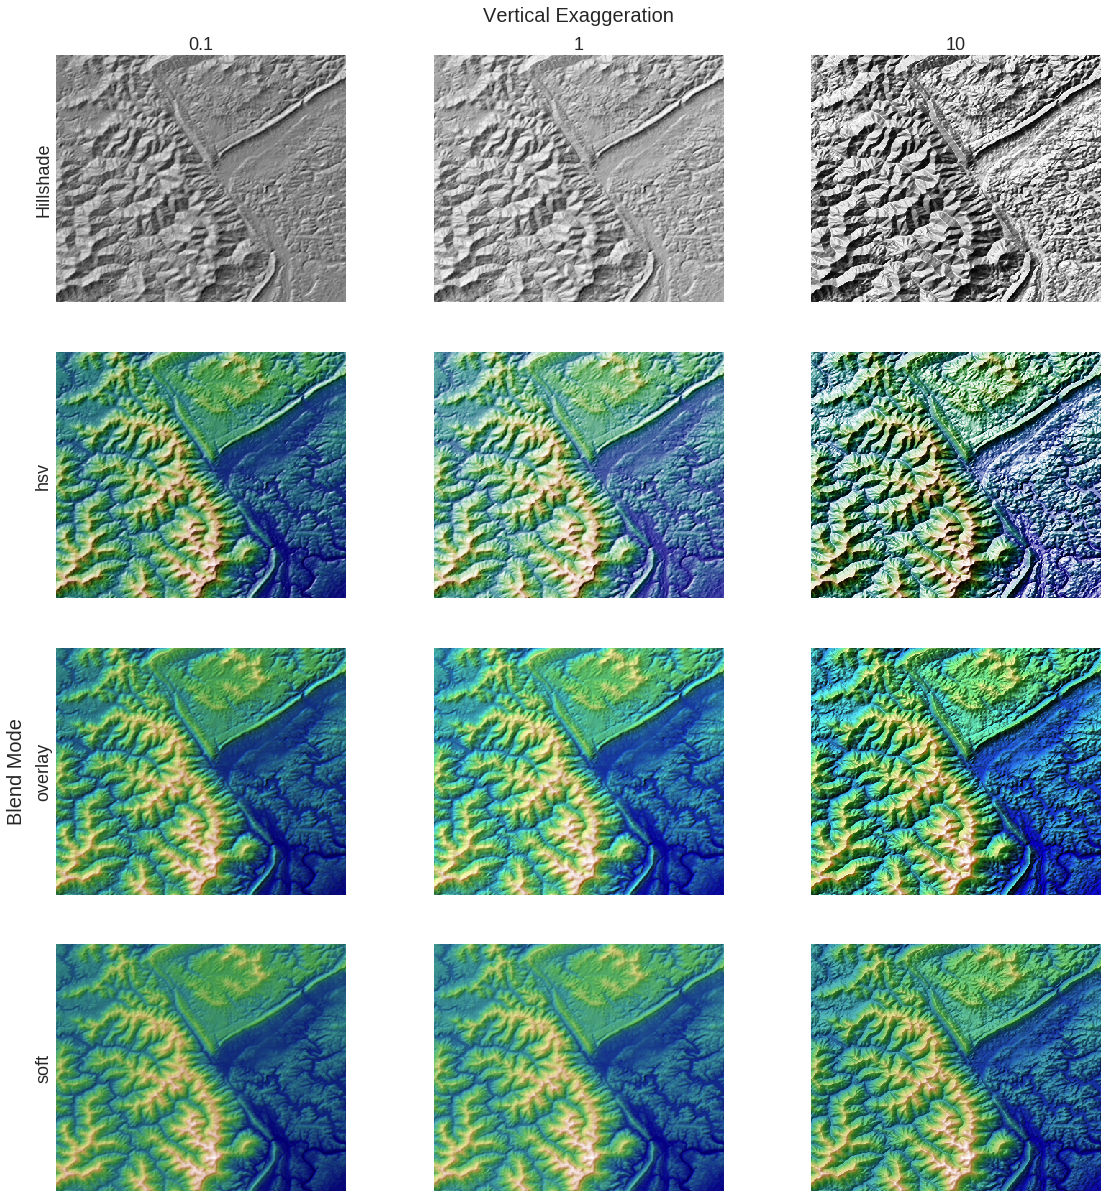

In [41]:
# TODO - your code here
# Use what we did live in lecture as an example
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource


with np.load(get_sample_data('jacksboro_fault_dem.npz')) as dem:
    z = dem['elevation']

    #-- Optional dx and dy for accurate vertical exaggeration ----------------
    # If you need topographically accurate vertical exaggeration, or you don't
    # want to guess at what *vert_exag* should be, you'll need to specify the
    # cellsize of the grid (i.e. the *dx* and *dy* parameters).  Otherwise, any
    # *vert_exag* value you specify will be relative to the grid spacing of
    # your input data (in other words, *dx* and *dy* default to 1.0, and
    # *vert_exag* is calculated relative to those parameters).  Similarly, *dx*
    # and *dy* are assumed to be in the same units as your input z-values.
    # Therefore, we'll need to convert the given dx and dy from decimal degrees
    # to meters.
    dx, dy = dem['dx'], dem['dy']
    dy = 111200 * dy
    dx = 111200 * dx * np.cos(np.radians(dem['ymin']))
    #-------------------------------------------------------------------------

# Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 19))
plt.setp(axes.flat, xticks=[], yticks=[])

# Vary vertical exaggeration and blend mode and plot all combinations
for col, ve in zip(axes.T, [0.1, 1, 10]):
    # Show the hillshade intensity image in the first row
    col[0].imshow(ls.hillshade(z, vert_exag=ve, dx=dx, dy=dy), cmap='gray')

    # Place hillshaded plots with different blend modes in the rest of the rows
    for ax, mode in zip(col[1:], ['hsv', 'overlay', 'soft']):
        rgb = ls.shade(z, cmap=cmap, blend_mode=mode,
                       vert_exag=ve, dx=dx, dy=dy)
        ax.imshow(rgb)

# Label rows and columns
for ax, ve in zip(axes[0], [0.1, 1, 10]):
    ax.set_title('{0}'.format(ve), size=18)
for ax, mode in zip(axes[:, 0], ['Hillshade', 'hsv', 'overlay', 'soft']):
    ax.set_ylabel(mode, size=18)

# Group labels...
axes[0, 1].annotate('Vertical Exaggeration', (0.5, 1), xytext=(0, 30),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='center', va='bottom', size=20)
axes[2, 0].annotate('Blend Mode', (0, 0.5), xytext=(-30, 0),
                    textcoords='offset points', xycoords='axes fraction',
                    ha='right', va='center', size=20, rotation=90)
fig.subplots_adjust(bottom=0.05, right=0.95)

plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

**A:** *This is a sample matplotlib example showing the changing in lighting on a hillside. I modified the figure sizes to go gain a clearer graphical detail of the image. Hopefully, this would be slightly more visually appealing from a detailed perscpecitve.*

2.  What was the most challenging part of what you did?


**A:** *The most challenging was grasping was testing the different visual settings in the code to adjust it to make it more meaningful to others.* 

3.  What was the most interesting thing you learned?

**A:** *What i find as interesting iwth not just this example but python overall is that just as in the example there many times that more than one library is needed to analyze/visualize the data and to meet the necesary parameters for what is trying to be achieved.*

4.  What area would you like to explore with more time?

**A:** * I want to learn more of how to use the available python libraries to build solutions that incorporate both speech analysis and image recognition for AI applications.




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.